In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from collections import defaultdict
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5 # the relative size  of legend markers vs original
plt.rcParams['legend.handletextpad'] = .5
plt.rcParams['legend.labelspacing'] = .4 # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = .5
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

# 1. Распределение Стьюдента

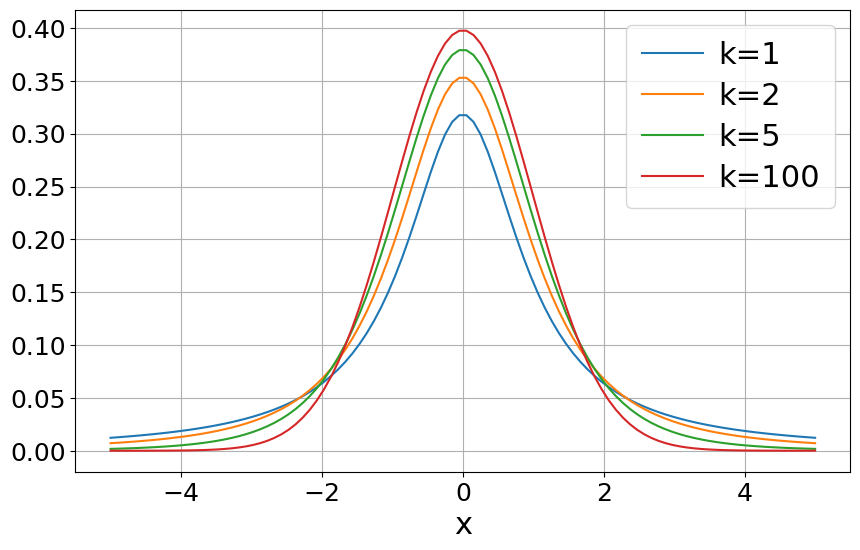

In [3]:
# распределение статистики Стьюдента
X = np.linspace(-5, 5, 100)

list_k = [1, 2, 5, 100]

for k in list_k:
    Y = stats.t.pdf(X, k)
    plt.plot(X, Y, label=f'k={k}')
plt.legend()
plt.xlabel('x')
plt.grid()

In [4]:
def get_student_parameter(data_one: np.array, data_two: np.array) -> float:
    """Вычисляет параметр функции распределения Стьюдента"""
    len_one, len_two = len(data_one), len(data_two)
    mean_one, mean_two = np.mean(data_one), np.mean(data_two)
    std_one, std_two =  np.std(data_one), np.std(data_two)
    k = (
        ((std_one ** 2) / len_one + (std_two ** 2) / len_two) ** 2
        / (
            (std_one ** 4) / ((len_one ** 2) * (len_one - 1))
            + (std_two ** 4) / ((len_two ** 2) * (len_two - 1)))
        )
    return k

def get_ttest_statistic(data_one: np.array, data_two: np.array) -> float:
    """Считает статистику Стьюдента"""
    len_one = len(data_one)
    len_two = len(data_two)
    mean_one = np.mean(data_one)
    mean_two = np.mean(data_two)
    std_one = np.std(data_one, ddof=1)
    std_two = np.std(data_two, ddof=1)
    t = (mean_one - mean_two) /np.sqrt((std_two ** 2 / len_two) + (std_one ** 2) / len_one)
    return t

In [5]:
# данные для примера
np.random.seed(44)
sample_size = 100
data_control = -np.random.normal(1, 1, sample_size)
data_pilot = -np.random.normal(1.2, 1, sample_size)

k = get_student_parameter(data_control, data_pilot)
print(f'student_parameter = {k}')

alpha = .05
critical_region_bounds = stats.t.ppf([alpha/2, 1 - alpha/2], df=k)
print(f'critical_region_bounds = {critical_region_bounds}')

ttest_statistic = get_ttest_statistic(data_control, data_pilot)
print(f'ttest_statistic = {ttest_statistic}')

pvalue = stats.t.cdf(-np.abs(ttest_statistic), df=k) * 2
print(f'pvalue = {pvalue}')

# сверим с готовой реализацией
print(f'stats.ttest_ind = {stats.ttest_ind(data_control, data_pilot)}')



student_parameter = 196.53643393447297
critical_region_bounds = [-1.97210778  1.97210778]
ttest_statistic = 1.8203056424009751
pvalue = 0.0702335577441075
stats.ttest_ind = TtestResult(statistic=1.8203056424009751, pvalue=0.07022230781028711, df=198.0)


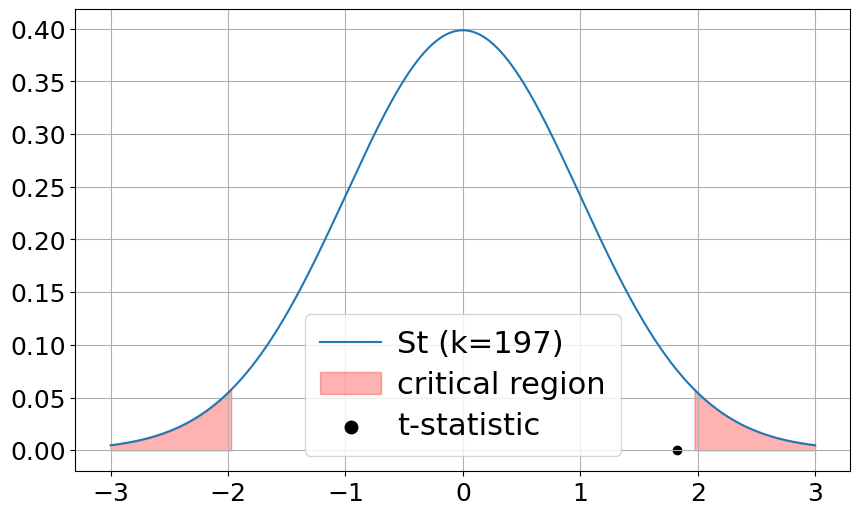

In [6]:
# Визуализация 
X = np.linspace(-3, 3, 1000)
Y = stats.t.pdf(X, k)

plt.plot(X, Y, label=f'St (k={k:.0f})')
# critical region
critical_mask_list = [X < critical_region_bounds[0], X > critical_region_bounds[1]]
for idx, mask in enumerate(critical_mask_list):
    X_ = X[mask]
    Y_upper = Y[mask]
    Y_down = np.zeros(len(Y_upper))
    plt.fill_between(
        X_, Y_down, Y_upper,
        color='r', alpha=.3,
        label='critical region' if idx == 0 else ''
    )
    
plt.scatter([ttest_statistic], [0], color='k', label='t-statistic')

plt.legend()
plt.grid()
plt.show()

# 2. Статистические тесты

```
scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='two-sided')
```

```
scipy.stats.mannwhitneyu(x, y, use_continuity=True, alternative=None)
```

In [7]:
def check_ttest(a, b, alpha=.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = stats.ttest_ind(a, b)
    return int(pvalue < alpha)

def check_mannwhitneyu(a, b, alpha=.05):
    """Тест Манн-Уитни. Возвращает 1, если отличия значимы."""
    _, pvalue = stats.mannwhitneyu(a, b, alternative='two-sided')
    return int(pvalue < alpha)

def check_bootstrap(a, b, func=np.mean, B=1000, alpha=.05):
    """Бутстрап. Возвращает 1, если отличия значимы."""
    a_bootstrap = np.random.choice(a, size=(len(a), B))
    b_bootstrap = np.random.choice(b, size=(len(b), B))
    list_diff = func(a_bootstrap, axis=0) - func(b_bootstrap, axis=0)
    left_bound = np.quantile(list_diff, alpha / 2)
    right_bound = np.quantile(list_diff, 1 - alpha / 2)
    res = 1 if (left_bound > 0) or (right_bound < 0) else 0
    return res

dict_tests = {
    'ttest': check_ttest,
    'mannwhitneyu': check_mannwhitneyu,
    'bootstrap': check_bootstrap
    
}

### Проверим, что тесты работают корректно
Запустим их на выборках из одинаковых распределений, убедимся что они редко ошибочно находят эффект

In [8]:
significant_results = defaultdict(list)

for _ in tqdm(range(1000)):
    a = np.random.normal(0, 1, 100)
    b = np.random.normal(0, 1, 100)
    for test_name, test in dict_tests.items():
        significant_results[test_name].append(test(a, b))

print({test_name: np.mean(rejected) for test_name, rejected in significant_results.items()})

  0%|          | 0/1000 [00:00<?, ?it/s]

{'ttest': 0.045, 'mannwhitneyu': 0.045, 'bootstrap': 0.051}


In [9]:
significant_results = defaultdict(list)

for _ in tqdm(range(1000)):
    a = np.random.normal(0, 1, 100)
    b = np.random.normal(0.4, 1, 100)
    for test_name, test in dict_tests.items():
        significant_results[test_name].append(test(a, b))

print({test_name: np.mean(rejected) for test_name, rejected in significant_results.items()})

  0%|          | 0/1000 [00:00<?, ?it/s]

{'ttest': 0.824, 'mannwhitneyu': 0.793, 'bootstrap': 0.828}


### Скорость работы
Видим, что вычисления занимают некоторое время. Сравним скорость вычисления тестов в зависимости от размера выборки.

In [10]:
test_times = {test_name: [] for test_name in dict_tests}
sample_sizes = np.logspace(2, 5, 20).astype(int)

for sample_size in tqdm(sample_sizes):
    a = np.random.normal(0, 1, sample_size)
    b = np.random.normal(0, 1, sample_size)
    for test_name, test in dict_tests.items():
        t1 = time.time()
        test(a, b)
        t2 = time.time()
        test_times[test_name].append(t2 - t1)

  0%|          | 0/20 [00:00<?, ?it/s]

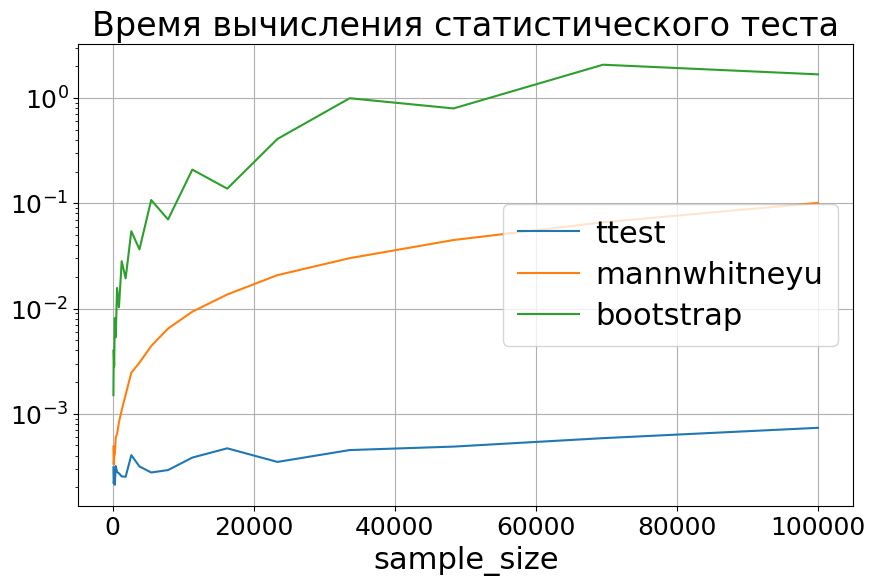

In [11]:
for test_name, times in test_times.items():
    plt.plot(sample_sizes, times, label=test_name)
plt.title('Время вычисления статистического теста')
plt.grid()
plt.xlabel('sample_size')
plt.yscale('log')
plt.legend()

In [12]:
dict_tests = {test_name: dict_tests[test_name] for test_name in ['ttest', 'mannwhitneyu']}

# Ошибки первого и второго рода

In [13]:
def aab_sample_generator(dist_a, dist_b):
    def _get_aab_sample(sample_size):
        a_one = dist_a.rvs(size=sample_size)
        a_two = dist_a.rvs(size=sample_size)
        b = dist_b.rvs(size=sample_size)
        return (a_one, a_two, b)
    return _get_aab_sample

def run_experiment(sample_sizes, aab_sample_generator, N=1000):
    first_type_errors = defaultdict(list)
    second_type_errors = defaultdict(list)

    for sample_size in tqdm(sample_sizes):
        aa_results = defaultdict(list)
        ab_results = defaultdict(list)
        for _ in range(N):
            a_one, a_two, b = aab_sample_generator(sample_size)
            for name, test in dict_tests.items():
                aa_results[name].append(test(a_one, a_two))
                ab_results[name].append(test(a_one, b))
    
        for name in dict_tests:
            first_type_errors[name].append(np.mean(aa_results[name]))
            second_type_errors[name].append(1 - np.mean(ab_results[name]))

    return sample_size, first_type_errors, second_type_errors

def plot_errors(x, data: dict, title='', xlabel=''):
    for key, values in data.items():
        plt.plot(x, values, label=key)

    plt.legend()
    plt.ylim([-.05, 1.05])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.grid()
    plt.show()

# Сравнение двух смещенных нормальных распределений

  0%|          | 0/10 [00:00<?, ?it/s]

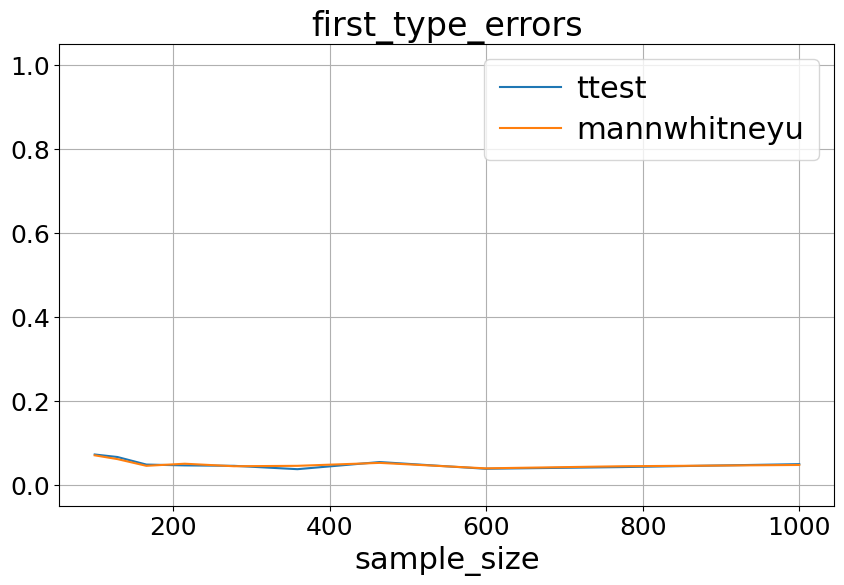

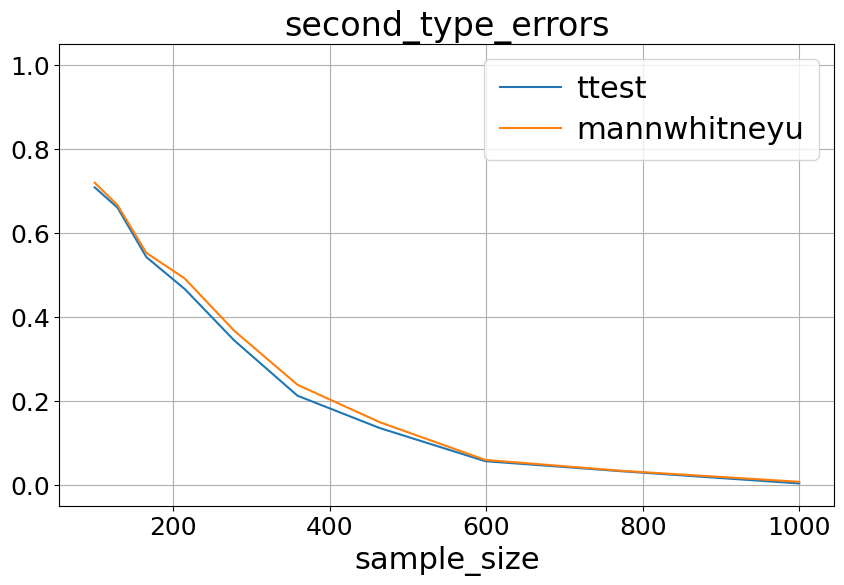

In [14]:
sample_sizes = np.logspace(2, 3, 10).astype(int)

generator = aab_sample_generator(
    dist_a = stats.norm(loc=0, scale=1),
    dist_b = stats.norm(loc=0.2, scale=1)
)

_, first_type_errors, second_type_errors = run_experiment(sample_sizes, generator)
plot_errors(sample_sizes, first_type_errors, 'first_type_errors', 'sample_size')
plot_errors(sample_sizes, second_type_errors, 'second_type_errors', 'sample_size')

# Сравнение для ненормально распределенных данных
Проверим как будут вести себя тесты при генерации данных из экспоненциального распределения.

  0%|          | 0/10 [00:00<?, ?it/s]

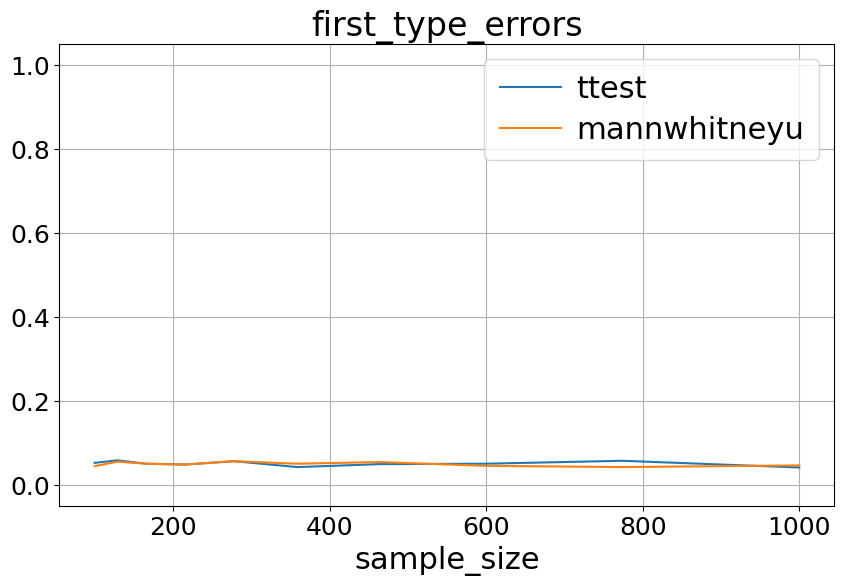

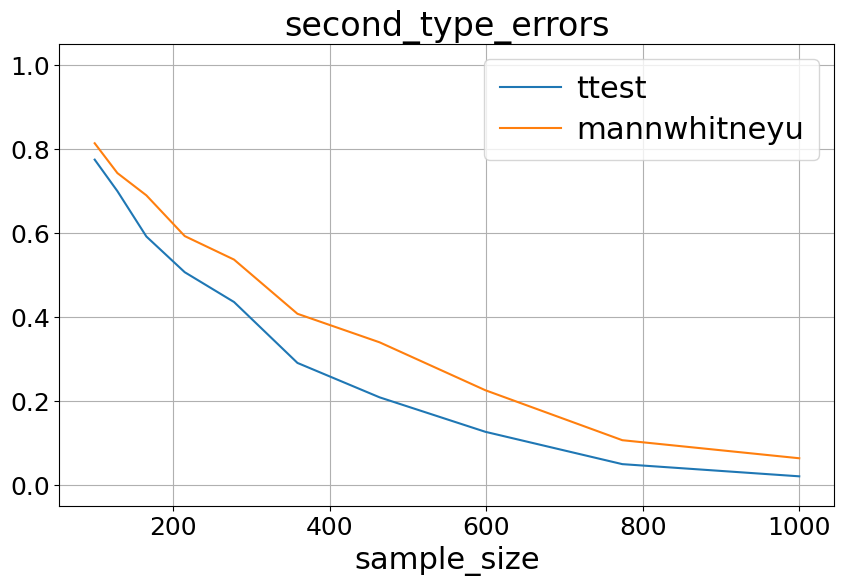

In [15]:
sample_sizes = np.logspace(2, 3, 10).astype(int)

generator = aab_sample_generator(
    dist_a = stats.expon(loc=0, scale=1.0),
    dist_b = stats.expon(loc=0, scale=1.2)
)

_, first_type_errors, second_type_errors = run_experiment(sample_sizes, generator)
plot_errors(sample_sizes, first_type_errors, 'first_type_errors', 'sample_size')
plot_errors(sample_sizes, second_type_errors, 'second_type_errors', 'sample_size')

# Чувствительность к выбросам
Проверим, как ведут себя тесты при наличии выбросов в данных.
Зафиксируем размер выборки, будем заменять одно значение в одной выборке на сильно отличающееся от среднего.

In [ ]:
N = 1000
tune_me = 3

outliers = np.arange(-150, 300 + 1, 15)
test_first_type_errors = defaultdict(list)
test_second_type_errors = defaultdict(list)
sample_size = 500

for outlier in tqdm(outliers):
    test_first_type_results = defaultdict(list)
    test_second_type_results = defaultdict(list)
    for _ in range(N):
        a_one = np.random.normal(0, 1, sample_size)
        a_one[0] = outlier
        a_two = np.random.normal(0, 1, sample_size)
        b = np.random.normal(.2, 1, sample_size)
        for test_name, test in dict_tests.items():
            result_aa = test(a_one, a_two)
            result_ab = test(a_one, b)
            test_first_type_results[test_name].append(result_aa)
            test_second_type_results[test_name].append(result_ab)

    for test_name in dict_tests:
        test_first_type_errors[test_name].append(np.mean(test_first_type_results[test_name]))
        test_first_type_errors[test_name].append(1 - np.mean(test_second_type_results[test_name]))



  0%|          | 0/31 [00:00<?, ?it/s]

In [ ]:
plot_errors(outliers, test_first_type_errors, 'first_type_errors', 'outlier')
plot_errors(outliers, test_second_type_errors, 'second_type_errors', 'outlier')